# Imports

In [2]:
# Python Imports
import os
import shutil
import random
import glob
import itertools

# Third-party Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Tensorflow Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report

# Data processing

In [3]:
# Dataset can be found at: https://www.kaggle.com/dhruvmak/face-mask-detection


In [4]:
home_dir = os.path.expanduser('~')
project_dir = f'{home_dir}/Projects/keras'

In [5]:
# Changing into dataset directory
os.chdir(f'{project_dir}/data/mask-vs-without-mask')

In [6]:
#Organize data into train, valid, test dirs
if os.path.isdir('train/with_mask') is False:
    os.makedirs('train/with_mask')
    os.makedirs('train/without_mask')
    os.makedirs('valid/with_mask')
    os.makedirs('valid/without_mask')
    os.makedirs('test/with_mask')
    os.makedirs('test/without_mask')
        
    for c in random.sample(os.listdir(f'with_mask'), 165):
        shutil.move(f'with_mask/{c}', 'train/with_mask')
    for c in random.sample(os.listdir(f'without_mask'), 165):
        shutil.move(f'without_mask/{c}', 'train/without_mask')
    for c in random.sample(os.listdir(f'with_mask'), 35):
        shutil.move(f'with_mask/{c}', 'valid/with_mask')
    for c in random.sample(os.listdir(f'without_mask'), 35):
        shutil.move(f'without_mask/{c}', 'valid/without_mask')
    for c in random.sample(os.listdir(f'with_mask'), 20):
        shutil.move(f'with_mask/{c}', 'test/with_mask')
    for c in random.sample(os.listdir(f'without_mask'), 20):
        shutil.move(f'without_mask/{c}', 'test/without_mask')
        
    os.rmdir('with_mask')
    os.rmdir('without_mask')

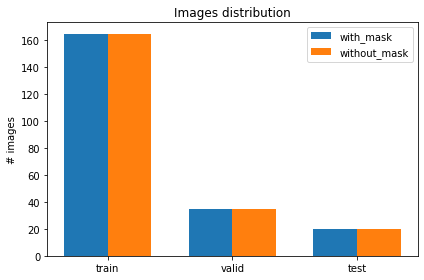

In [7]:
labels = ['with_mask', 'without_mask']
datasets = []
with_mask = []
without_mask = []

for folder_name in os.listdir():
    path = os.path.join(project_dir, 'data', 'mask-vs-without-mask', folder_name)
    
    datasets.append(folder_name)
    
    for children_name in os.listdir(path):
        child_path = os.path.join(path, children_name)
        if children_name == labels[0]:
            with_mask.append(len(os.listdir(child_path)))
        else:
            without_mask.append(len(os.listdir(child_path)))
            
x = np.arange(len(datasets))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, with_mask, width, label=labels[0])
rects2 = ax.bar(x + width/2, without_mask, width, label=labels[1])

ax.set_ylabel('# images')
ax.set_title('Images distribution')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()

fig.tight_layout()
plt.show()

In [8]:
# going back to root directory
os.chdir(project_dir)

In [9]:
train_path = f'{project_dir}/data/mask-vs-without-mask/train'
valid_path = f'{project_dir}/data/mask-vs-without-mask/valid'
test_path = f'{project_dir}/data/mask-vs-without-mask/test'

In [10]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224, 224), classes=['with_mask', 'without_mask'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224, 224), classes=['with_mask', 'without_mask'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224, 224), classes=['with_mask', 'without_mask'], batch_size=10, shuffle=False)

Found 330 images belonging to 2 classes.
Found 70 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [11]:
# This function will plot images in the form of a grid with 1 row and 10 columns where 
# images are placed
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [12]:
img, labels = next(train_batches)  # gets a single batch of imgs and labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


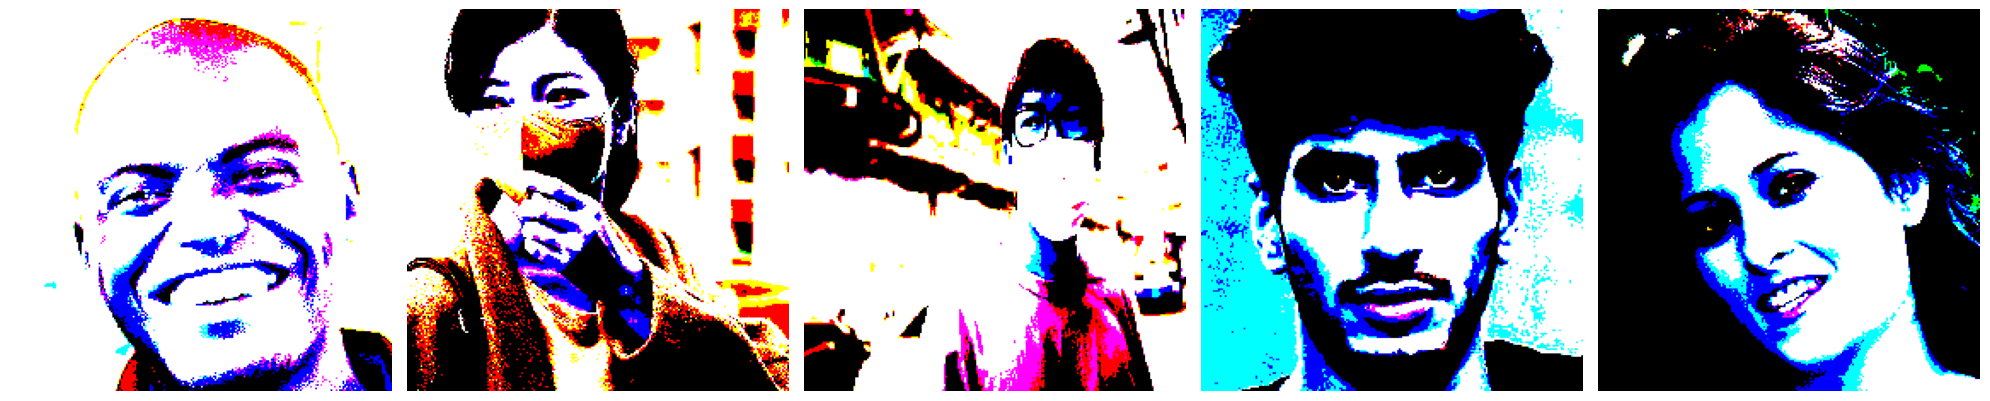

In [13]:
plotImages(img)

## Importing VGG16 model

In [37]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [15]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [41]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [42]:
for layer in model.layers[:-2]:
    layer.trainable = False

In [43]:
model.add(Dense(units=2, activation='softmax'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

# Train the fine-tuned VGG16 model

In [20]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
n_epochs = 10

history = model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=n_epochs,
          verbose=1
)

Epoch 1/10
33/33 [==============================] - 141s 4s/step - loss: 0.2452 - accuracy: 0.9727 - val_loss: 0.0745 - val_accuracy: 0.9857
Epoch 2/10
33/33 [==============================] - 142s 4s/step - loss: 0.0508 - accuracy: 0.9939 - val_loss: 0.0154 - val_accuracy: 0.9857
Epoch 3/10
33/33 [==============================] - 142s 4s/step - loss: 2.6045e-07 - accuracy: 1.0000 - val_loss: 0.0845 - val_accuracy: 0.9857
Epoch 4/10
33/33 [==============================] - 142s 4s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0693 - val_accuracy: 0.9857
Epoch 5/10
33/33 [==============================] - 142s 4s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0687 - val_accuracy: 0.9857
Epoch 6/10
33/33 [==============================] - 142s 4s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0687 - val_accuracy: 0.9857
Epoch 7/10
33/33 [==============================] - 142s 4s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0687 - val_accuracy: 

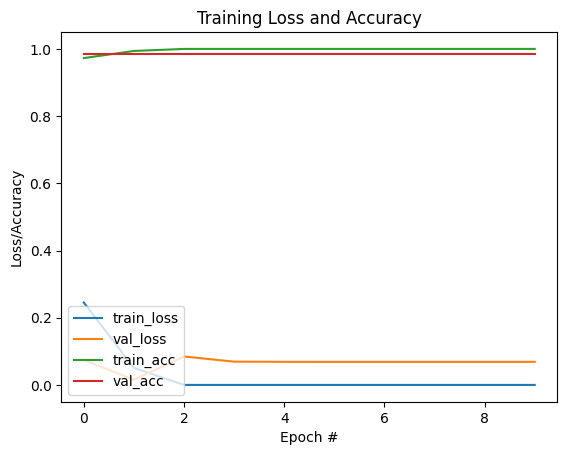

In [22]:
plt.figure()
plt.plot(np.arange(0, n_epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, n_epochs), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, n_epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, n_epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

# Saving de model

In [23]:
# Checks first to see if file exists already.
# If not, the model is saved to disk
# if os.path.isfile(f'{project_dir}/models/vgg16_with_mask_vs_without_mask_model.h5') is False:
#     model.save(f'{project_dir}/models/vgg16_with_mask_vs_without_mask_model.h5')

# Loading Model

In [24]:
# model = load_model(f'{project_dir}/models/vgg16_with_mask_vs_without_mask_model.h5')

# Predict using fine-tuned VGG16 model

In [25]:
predictions = model.predict(x=test_batches, verbose=0)

In [26]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

Confusion matrix, without normalization


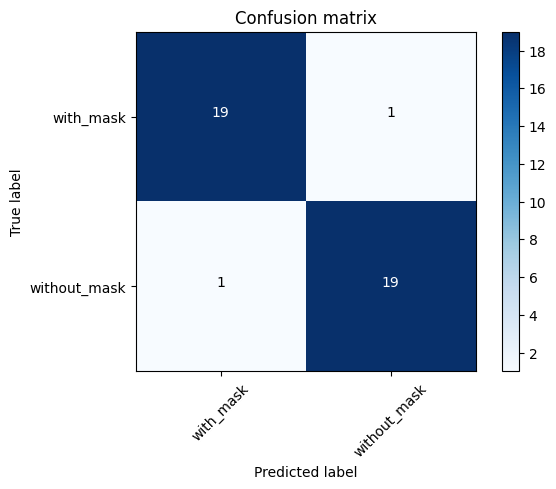

In [28]:
cm_plot_labels = ['with_mask', 'without_mask']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels)

In [29]:
# Classification report
print(classification_report(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1)))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.95      0.95      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



In [30]:
batch_size = 10
pred_labels = np.argmax(predictions, axis=-1)
index = 0

mislabeled_images = []
mislabeled_labels = []
true_labels = []

for i in range(0, len(test_batches)):
    img, labels = next(test_batches)
    labels = np.argmax(labels, axis=-1)
    
    predicted_labels = pred_labels[index:(index + batch_size)]
    
    corrected_predicted = (labels == predicted_labels)
    mislabeled_indices = np.where(corrected_predicted == 0)[0]
        
    if(len(mislabeled_indices) != 0):        
        mislabeled_images += [img for img in img[mislabeled_indices]]
        mislabeled_labels += [label for label in predicted_labels[mislabeled_indices]]
        true_labels += [label for label in labels[mislabeled_indices]]
        
    index += batch_size

In [31]:
def display_examples(class_names, mislabeled_images, mislabeled_labels, true_labels):
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle("Some images that where incorrected predicted", fontsize=16, x= 0.5, y=0.98)
    for i in range(len(mislabeled_images)):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(mislabeled_images[i], cmap=plt.cm.binary)
        plt.xlabel('prediction: {}\n label: {}'.format(class_names[mislabeled_labels[i]], class_names[true_labels[i]]))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


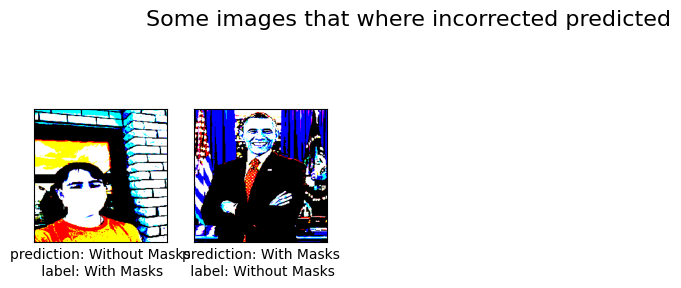

In [32]:
display_examples(['With Masks', 'Without Masks'], mislabeled_images[:5], mislabeled_labels[:5], true_labels[:5])